<a href="https://colab.research.google.com/github/6309659107/scanner-images/blob/main/DSI206_Project_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## เลือกรูปของคุณ 🖼
คุณสามารถเลือกรูปภาพจากตัวอย่าง หรือนำเข้ารูปภาพของคุณได้

In [ ]:
#@title{display-mode: "form"}
import os
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from google.colab import files
from IPython.display import HTML

image = '\uD83D\uDCE4 upload your image' #@param ['🗏 page', '🧾 receipt', '📤 upload your image']

image = ' '.join(image.split(' ')[1:])
onedrive_dataset = None

image_url = {
  'page': 'https://tuipied-my.sharepoint.com/:i:/g/personal/sarung_staff_tu_ac_th/EYrbOpH-4KxKh92HODIIu14BtZ-2t7tPW2BAqpK9cpCPwA?download=1',
  'receipt': 'https://tuipied-my.sharepoint.com/:i:/g/personal/sarung_staff_tu_ac_th/Eas6Z4A_v0JBr8r-AEgh8VQBeOoOWC2tdZtEPc_CJ3RPNw?download=1'
}

if image == 'upload your image': onedrive_dataset = ':images_upload:'
elif image in image_url:  onedrive_dataset = image_url[image]
if onedrive_dataset == None: raise Exception('Cannot select image')

preupload_datasets = None
if onedrive_dataset == ':images_upload:':
  display(HTML('<h3>Select your image</h3>'))
  # display(HTML('<p/>You can select multiple images by pressing ctrl, cmd or shift and click.<p>'))
  dir = os.getcwd()
  uploaded = files.upload()
  preupload_datasets = [os.path.join(dir, f) for f in uploaded.keys()]
  image_fn = preupload_datasets[0]
else:
  get_ipython().system_raw('wget -O image.jpg ' + onedrive_dataset)
  image_fn = 'image.jpg'
  # This code will be hidden when the notebook is loaded.
  #@markdown ---




Saving S__17604645.jpg to S__17604645 (1).jpg


# ติดตั้ง Library เพิ่มที่ใช้ในการเเสกนเอกสารได้เเก่

* imutils
* scikit-image
* pytesseract

In [ ]:
#@title{display-mode: "form"}
!pip install --upgrade imutils
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install -U scikit-image

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


# สร้างฟังก์ชั่นในการเเสกนเอกสาร
1. ฟังก์ชั่น order_point คือ การคำนวนหาจุดมุมทั้งสี่ของกระดาษ
2. ฟังก์ชั่น four_point_transform คือ การนำจุดมุมทั้งสี่ บิดรูปภาพเดิมให้ตั้งตรงโดยการใช้ค่าความสูงและความกว้างที่มากที่สุดจากการคำนวน

In [ ]:
# เก็บ Function และ Import
import numpy as np
import cv2
import pytesseract
import shutil
import os
import random
import imutils
from skimage import exposure
from skimage import data, io, filters
from skimage.filters import threshold_otsu, threshold_local
try:
    from PIL import Image
except ImportError:
    import Image
def order_points(pts):
	rect = np.zeros((4, 2), dtype = "float32") #เปลี่ยนชนิดของข้อมูลเพื่อให้ทำงานง่ายขึ้น
	s = pts.sum(axis = 1) #การรวมพิกัด (x, y) เข้าด้วยกัน ระหว่างซ้ายบนและขวาล่าง
	rect[0] = pts[np.argmin(s)] #จุดซ้ายบนจะมีผลรวมน้อยที่สุด = 0
	rect[2] = pts[np.argmax(s)] #จุดขวาล่างจะมีผลรวมมากที่สุด = 2
	diff = np.diff(pts, axis = 1) #หาความแตกต่างระหว่างพิกัด (x, y) ระหว่างจุดขวาบนและซ้ายล่าง
	rect[1] = pts[np.argmin(diff)] #จุดบนขวาจะมีความแตกต่างน้อยที่สุด = 1
	rect[3] = pts[np.argmax(diff)] #จุดซ้ายล่างจะมีความแตกต่างมากที่สุด = 3
	return rect #พอเราได้จุดทั้งสี่เเล้วจะรีเทิร์นค่าออกมา

def four_point_transform(image, pts):
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2)) #คำนวณความกว้างระหว่างพิกัด x ของจุดล่างขวาและจุดล่างซ้าย
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2)) #คำนวณความกว้างระหว่างพิกัด x ของจุดบนขวาและจุดบนซ้าย
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2)) #คำนวณความสูงระหว่างพิกัด y ของจุดบนขวาและจุดล่างขวา
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2)) #คำนวณความสูงระหว่างพิกัด y ของจุดบนซ้ายและจุดล่างซ้าย
	#เราใช้ค่าความสูงและความกว้างที่มากที่สุดจากการคำนวนเพื่อกำหนดขนาดของภาพรูปใหม่
	maxWidth = max(int(widthA), int(widthB))
	maxHeight = max(int(heightA), int(heightB)) 
	#สร้างเมทริกซ์มุมมอง birds eye view โดยเริ่มจาก มุมซ้ายบน ขวาบน ล่างขวา และล่างซ้ายตามลำดับ
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
	M = cv2.getPerspectiveTransform(rect, dst) #ใช้ getPerspective แปลงเมทริกซ์​ dst และส่งพิจัดจุดสี่มุม และระบุความกว้างและความสูงของภาพที่ส่งออก
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight)) #ใช้ warpPerspective ในการบิดรูปภาพเดิมจากพารามิเตอร์ความกว้างความสูงที่ได้รับจาก M
	return warped	

#ขั้นตอนที่ 1 : เเปลงภาพเป็นสีขาวดำ
> ***cv2.cvtColor*** ในการแปลงภาพเป็นขาวดำซึ่งจะช่วยให้เราสามารถหาขอบ มุมของกระดาษได้ง่ายขึ้น 







--------------- ขั้นตอนที่ 1 : แปลงภาพสีเป็นขาวดำ ---------------


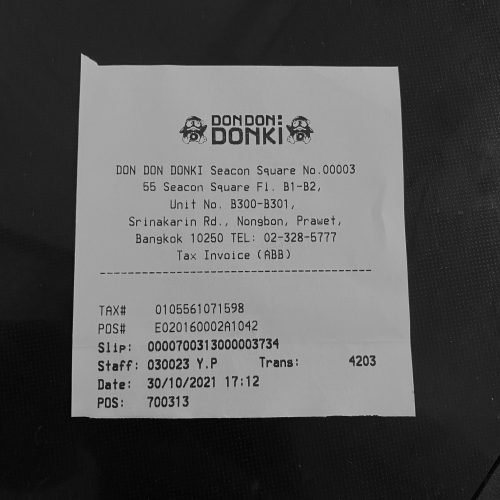

In [ ]:
image = cv2.imread(image_fn)
ratio = image.shape[0] / 500.0 
orig = image.copy()
image = imutils.resize(image, height = 500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print("--------------- ขั้นตอนที่ 1 : แปลงภาพสีเป็นขาวดำ ---------------")
cv2_imshow(gray)

# ขั้นตอนที่ 2 : การลดนอยซ์ของรูปภาพเเละหาขอบของภาพ


> ***cv2.erode*** ในการกร่อนภาพ เพื่อลบข้อมูลบริเวณขอบหรือเรียกว่าลดนอยซ์ 

> ***cv2.Canny*** ในการตรวจจับขอบของกระดาษ





--------------- ขั้นตอนที่ 2 : ลดนอยซ์และหาขอบ ---------------


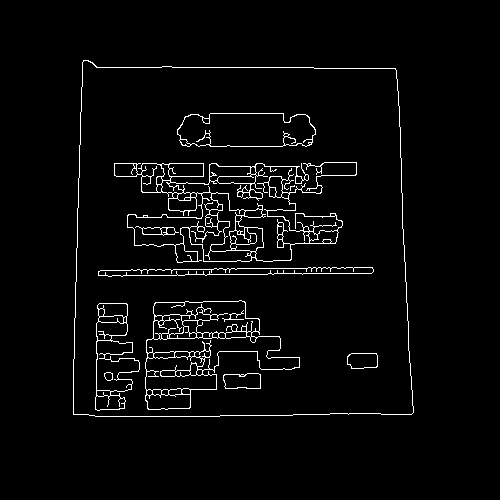

In [ ]:
kernel = np.ones((5, 5), np.uint8)
erosion = cv2.erode(gray, kernel, iterations=1)
#erode คือการกร่อนภาพ ในการลบข้อมูลภาพบริเวณขอบ ซึ่งส่งผลให้ขนาดภาพเล็กลง
opening = cv2.morphologyEx(erosion, cv2.MORPH_OPEN, kernel)
#opening เนื่องจาก erode ส่งผลให้ขนาดภาพเล็กลง เราจึงต้องคืนค่าภาพ cv2.MORPH_OPEN และใช้ในการลบขอบที่เป็นจุดๆ หรือลดนอยซ์
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
#closing คือการเชื่อมภาพที่แยกออกจากกันจากการที่ลดนอยซ์
edges = cv2.Canny(closing, 20, 240) 
#edges คือการตรวจจับขอบ
print("--------------- ขั้นตอนที่ 2 : ลดนอยซ์และหาขอบ ---------------")
cv2_imshow(edges)

# ขั้นตอนที่ 3 : หาขอบเขตของภาพกระดาษเเละจัดการเค้าโครงขอบให้มองเห็นเพิ่มมากขึ้น
> ***cv2.adaptiveThreshold*** ในการหาเกณฑ์ของกระดาษโดยการคิดค่าความสว่างบริเวณใกล้ๆ เเละพิจารณาว่าควรใช้จุดเปลี่ยนที่เท่าไหร่ โดยที่
*   *cv2.THRESH_BINARY_INV* คือหากค่าที่คิดสูงกว่าค่าจุดเปลี่ยนจะเป็น 0 ที่เหลือเป็น 255
*   *cv2.ADAPTIVE_THRESH_GAUSSIAN_C* คือการคำนวณค่าเฉลี่ยรอบข้าง โดยถ่วงน้ำหนักด้วยฟังก์ชันเกาส์



> ***cv2.findContours*** ในการหาเส้นเค้าโครงของภาพ โดยที่
*   *cv2.RETR_TREE*    คือการกำหนดชั้นของเส้นเค้าโครงโดยพิจารณาลำดับชั้นโดยไล่จากเค้าโครงด้านในไปเรื่อยๆ
*   *cv2*.*CHAIN_APPROX_NONE*  คือการหาเค้าโครงแบบละเอียดเป็นจุดต่อจุด










--------------- ขั้นตอนที่ 3 : หาเกณฑ์ค่าภาพและหาขอบให้ดีขึ้น ---------------


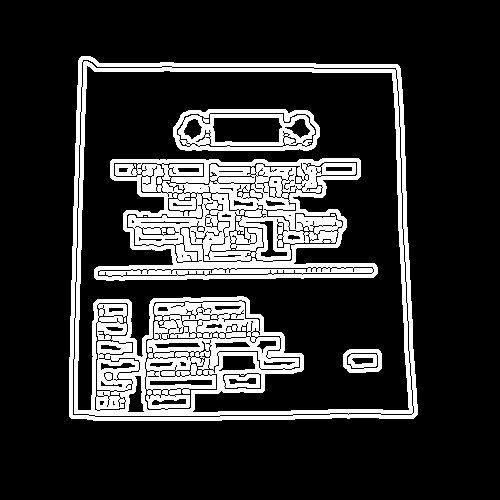

In [ ]:
thresh = cv2.adaptiveThreshold(edges, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 9, 1)  
#adaptivethresholding เป็นวิธีการเกณฑ์ที่คำนวณค่าขีด จำกัด สำหรับพื้นที่ต่างๆที่เล็กกว่าในรูปภาพ โดยใช้ผลรวมถ่วงน้ำหนักของค่าพื้นที่ใกล้เคียงที่น้ำหนักเป็นหน้าต่างเกาส์เซียน
contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)  
#findContours ในการหาขอบ 
#cv2.RETR_TREE คือการกำหนดชั้นของเส้นเค้าโครงโดยพิจารณาลำดับชั้นให้ตัวข้างในเป็นเค้าโครงลูกของตัวนอกไล่ไปเรื่อยๆ หรือเป็น mode ที่ทำการเก็บข้อมูลทั้งหมดมาทำเป็น contour
#cv2.CHAIN_APPROX_NONE คือการหาเค้าโครงแบบละเอียดเป็นจุดต่อจุด แต่ในกรณีทั่วไปจะใช้ cv2.CHAIN_APPROX_SIMPLE ซึ่งหมายถึงประมาณเอาเท่าที่จำเป็น
print("--------------- ขั้นตอนที่ 3 : หาเกณฑ์ค่าภาพและหาขอบให้ดีขึ้น ---------------")
cv2_imshow(thresh)

# ขั้นตอนที่ 4 : หาขอบของกระดาษ
> ทำการสร้างลูปให้ว่า "*ถ้าเจอมุมครบ 4 จุด ให้เท่ากับหน้าของกระดาษ* "โดยที่
*   *cv2.arcLength* คือการหาความยาวของเค้าโครงที่หาได้จากขั้นตอน 3
*   *cv2.approxPolyDP* คือการหาจำนวนมุมของวัตถุ ในที่นี้หากเป็นกระดาษเราจึงกำหนดค่าเท่ากับ 4 มุม



--------------- ขั้นตอนที่ 4 : หาขอบของรูปภาพ ---------------


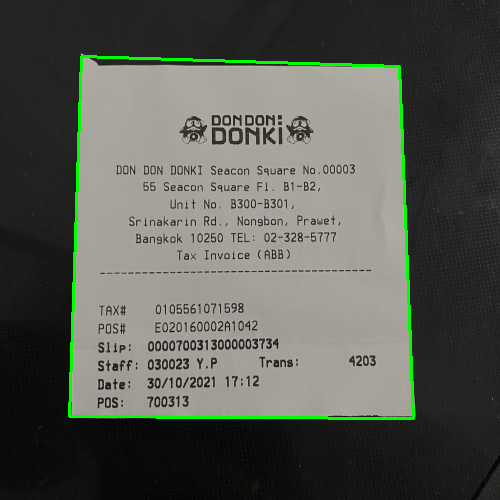

In [ ]:
cnts = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
#สร้างลูปโดยที่ถ้าเจอมุมครบ 4 จุดแล้วให้เท่ากับเจอหน้าจอเราแล้ว
for c in cnts:
	peri = cv2.arcLength(c, True) #arcLength เป็นหาความยาวของเส้นเค้าโครงที่หาได้
	approx = cv2.approxPolyDP(c, 0.02 * peri, True) #approxPolyDP เป็นฟังก์ชั่นหาจำนวนมุมของวัตถุ
	if len(approx) == 4:
		screenCnt = approx
		break
print("--------------- ขั้นตอนที่ 4 : หาขอบของรูปภาพ ---------------")
cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
cv2_imshow(image)

# ขั้นตอนที่ 5 : การนำขอบของรูปภาพมาบิดรูปภาพให้ตั้งตรง
โดยการเรียกใช้ฟังก์ชั่น *four_point_transform* จากที่เราได้เขียนไว้ตอนเเรก เพื่อที่จะเเสดงภาพของผลลัพท์ที่ได้

--------------- ขั้นตอนที่ 5 : แสดงภาพของผลลัพท์ ---------------


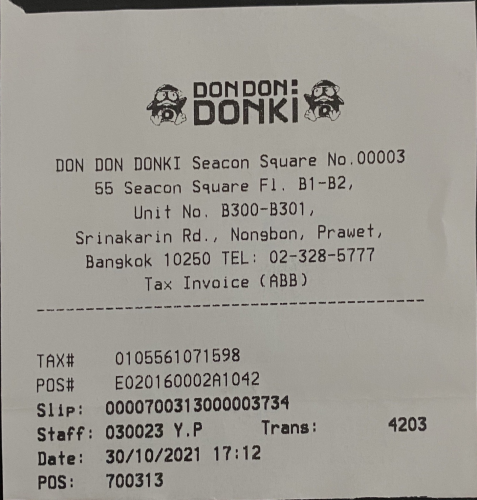

In [ ]:
#เเสดงภาพผลลัพท์ที่คำนวนได้จากมุมมอง bird eye view
result = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)
warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)
print("--------------- ขั้นตอนที่ 5 : แสดงภาพของผลลัพท์ ---------------")
cv2_imshow(imutils.resize(result, height = 500))

# ขั้นตอนที่ 6 : การเพิ่มเเสงของภาพผลลัพท์เพื่อนำรูปภาพไปใช้ต่อ
> ***exposure.rescale_intensity*** เป็น method การรับเเสง โดยที่กำหนดให้ ค่าต่ำสุดจะกลายเป็นสีดำ (0) และค่าสูงสุดจะกลายเป็นสีขาว (255)



--------------- ขั้นตอนที่ 6 : ภาพของผลลัพท์เมื่อรับแสงเข้าเพิ่ม ---------------


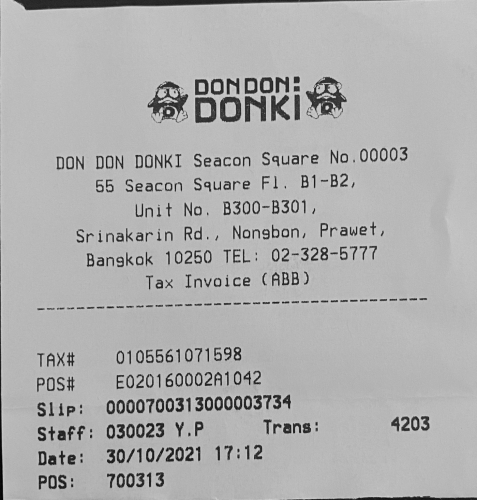

In [ ]:
warped = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
warped = exposure.rescale_intensity(warped, out_range = (0, 255)) 
#ใช้เมธอด rescale_intensity รับแสงของ skimage
#ค่าต่ำสุดจะกลายเป็นสีดำ (ค่า 0) และค่าสูงสุดจะกลายเป็นสีขาว (ค่า 255)
(h, w) = warped.shape
(dX, dY) = (int(w * 1), int(h * 1))
crop = warped[10:dY, w - dX:w - 10]
print("--------------- ขั้นตอนที่ 6 : ภาพของผลลัพท์เมื่อรับแสงเข้าเพิ่ม ---------------")
cv2_imshow(imutils.resize(crop, height = 500))

# ขั้นตอนที่ 7 : การเเปลงภาพให้มีเเต่สีขาวและดำเท่านั้น
> ***threshold_local*** เป็นการคำนวณเกณฑ์ในพื้นที่ที่ลบด้วยค่าออฟเซ็ต เพื่อทำให้เหมือนกับการเเสกนเอกสารผ่านเครื่องพิมพ์

เราสามารถปรับค่า offset ได้ตามที่ต้องการ เพื่อความชัดเจนของตัวอักษร

--------------- ขั้นตอนที่ 7 : ภาพของผลลัพท์เมื่อแสกนเป็นไฟล์ขาวดำ ---------------


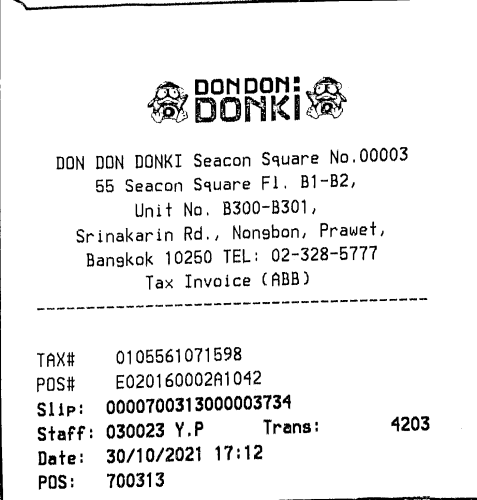

In [ ]:
#@title{display-mode: "form"}
block_size = 35
T = threshold_local(crop, block_size, 
                    offset=19#@param {type: "slider", min: 1, max: 100} 
                    )
#ใช้ฟังก์ชัน threshold_local ซึ่งคำนวณเกณฑ์ในพื้นที่ที่มีขนาด block_size ที่มีลักษณะเฉพาะซึ่งล้อมรอบแต่ละพิกเซล
#ค่าเกณฑ์แต่ละค่าคือค่าเฉลี่ยถ่วงน้ำหนักของพื้นที่ใกล้เคียงในพื้นที่ลบด้วยค่าออฟเซ็ต
scan_img = (crop > T).astype("uint8") * 255
print("--------------- ขั้นตอนที่ 7 : ภาพของผลลัพท์เมื่อแสกนเป็นไฟล์ขาวดำ ---------------")
cv2_imshow(imutils.resize(scan_img, height = 500))

# ขั้นตอนที่ 8 : การสกัดข้อความจากภาพ ด้วยเทคนิค OCR


In [ ]:
#เทคนิค OCR จากไลบรารี่ tesseract
extractedInformation = pytesseract.image_to_string(scan_img)
print(extractedInformation)

 

 

 

DON DON DONKI Seacon Square No .00003
55 Seacon Square Fl. B1~B2,
Unit No. B300-B301,
Srinakarin Rd., Nongbon, Prawet,
Bangkak 10250 TEL: 02-328-5777
Tax Invoice (ABB)

ee nae nn a te er oe on cn em me ca em mm my ae = SES

TAX# 0106561071598

POS# E020160002A1042

Slip: 000070031 3000003734

Staff: 030023 Y.P Trans: 4203
Date: 30/10/2021 17:12

Pos: 700313



# รูปภาพต้นฉบับเเละรูปภาพที่นำเข้าเครื่องเเสกน

------ รูปภาพต้นฉบับ ------


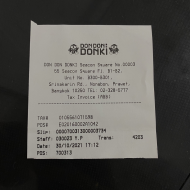

------ รูปภาพผลลัพธ์ ------


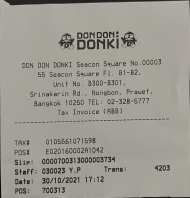

In [ ]:
#@title{display-mode: "form"}
height =           190 #@param {type: "slider", min: 100, max: 500}
print('------ รูปภาพต้นฉบับ ------')
cv2_imshow(imutils.resize(orig, height)) 
print('------ รูปภาพผลลัพธ์ ------')
cv2_imshow(imutils.resize(result, height))
# This code will be hidden when the notebook is loaded.
#@markdown ---